In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
max_df = pd.read_parquet("./final_data/max/final_data.parquet")
min_df = pd.read_parquet("./final_data/min/final_data.parquet")
mean_df = pd.read_parquet("./final_data/mean/final_data.parquet")
mode_df = pd.read_parquet("./final_data/mode/final_data.parquet")
std_df =  pd.read_parquet("./final_data/std/final_data.parquet")

In [3]:
with open("./feature_selection/features_mean.txt", "r") as f:
    mean_features = eval(f.read())
with open("./feature_selection/features_min.txt", "r") as f:
    min_features = eval(f.read())
with open("./feature_selection/features_max.txt", "r") as f:
    max_features = eval(f.read())
with open("./feature_selection/features_mode.txt", "r") as f:
    mode_features = eval(f.read())
with open("./feature_selection/features_std.txt", "r") as f:
    std_features = eval(f.read())


In [4]:
max_df.columns = max_df.columns.str.replace("-","_")
min_df.columns = min_df.columns.str.replace("-","_")
mean_df.columns = mean_df.columns.str.replace("-","_")
mode_df.columns = mode_df.columns.str.replace("-","_")
std_df.columns = std_df.columns.str.replace("-","_")

In [5]:
max_df.drop(["cumulative_hasfailed"], axis=1, inplace=True)
min_df.drop(["cumulative_hasfailed","hasfailed"], axis=1, inplace=True)
mean_df.drop(["cumulative_hasfailed","hasfailed"], axis=1, inplace=True)
mode_df.drop(["cumulative_hasfailed","hasfailed"], axis=1, inplace=True)
std_df.drop(["cumulative_hasfailed","hasfailed"], axis=1, inplace=True)

In [6]:
max_df = max_df[max_features+["aircraftSerNum_1","time_to_failure","date"]]
min_df = min_df[min_features+["aircraftSerNum_1","date"]]
mean_df = mean_df[mean_features+["aircraftSerNum_1","date"]]
mode_df = mode_df[mode_features+["aircraftSerNum_1","date"]]
std_df = std_df[std_features+["aircraftSerNum_1","date"]]

In [7]:
max_df.columns = max_df.add_suffix("_max").columns
min_df.columns = min_df.add_suffix("_min").columns
mean_df.columns = mean_df.add_suffix("_mean").columns
mode_df.columns = mode_df.add_suffix("_mode").columns
std_df.columns = std_df.add_suffix("_std").columns

max_df=max_df.rename({"aircraftSerNum_1_max":"aircraftSerNum_1"
               ,"date_max":"date"
               ,"time_to_failure_max":"time_to_failure"}
               ,axis=1)
mean_df=mean_df.rename({"aircraftSerNum_1_mean":"aircraftSerNum_1"
               ,"date_mean":"date"}
               ,axis=1)
min_df=min_df.rename({"aircraftSerNum_1_min":"aircraftSerNum_1"
                ,"date_min":"date"}
                ,axis=1)
mode_df=mode_df.rename({"aircraftSerNum_1_mode":"aircraftSerNum_1"
                ,"date_mode":"date"}
                ,axis=1)
std_df=std_df.rename({"aircraftSerNum_1_std":"aircraftSerNum_1"
                ,"date_std":"date"}
                ,axis=1)



In [8]:
max_df.drop_duplicates(subset=["aircraftSerNum_1","date"],keep="first",inplace=True)
min_df.drop_duplicates(subset=["aircraftSerNum_1","date"],keep="first",inplace=True)
mean_df.drop_duplicates(subset=["aircraftSerNum_1","date"],keep="first",inplace=True)
mode_df.drop_duplicates(subset=["aircraftSerNum_1","date"],keep="first",inplace=True)
std_df.drop_duplicates(subset=["aircraftSerNum_1","date"],keep="first",inplace=True)

In [9]:

df = pd.merge(max_df, min_df, on=["aircraftSerNum_1","date"],how="inner")

df = pd.merge(df, mean_df, on=["aircraftSerNum_1","date"],how="inner")

df = pd.merge(df, mode_df, on=["aircraftSerNum_1","date"],how="inner")

df = pd.merge(df, std_df, on=["aircraftSerNum_1","date"],how="inner")

df.drop(["aircraftSerNum_1","date"], axis=1, inplace=True)

In [10]:
X = df.drop(["time_to_failure","cumulative_duration_mean","cumulative_duration_mode","cumulative_duration_min"], axis=1)
y = df["time_to_failure"]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


GradientBoostingRegressor()

['cumulative_duration_std', 'cumulative_duration_max', 'bleedPrecoolDiffPress_1a_mean', 'bleedMonPress_2b_min', 'bleedPrecoolDiffPress_1a_max', 'bleedFavTmCmd_1a_mean', 'bleedFavTmFbk_1b_mean', 'bleedPrecoolDiffPress_1b_max', 'bleedPrecoolDiffPress_1a_min', 'bleedPrecoolDiffPress_2b_max', 'bleedPrsovFbk_1a_min', 'bleedMonPress_1a_min', 'bleedFavTmFbk_1b_min', 'basBleedOverPressF_2b_std', 'amscHprsovDrivF_2b_std', 'bleedFavTmFbk_1b_mode']


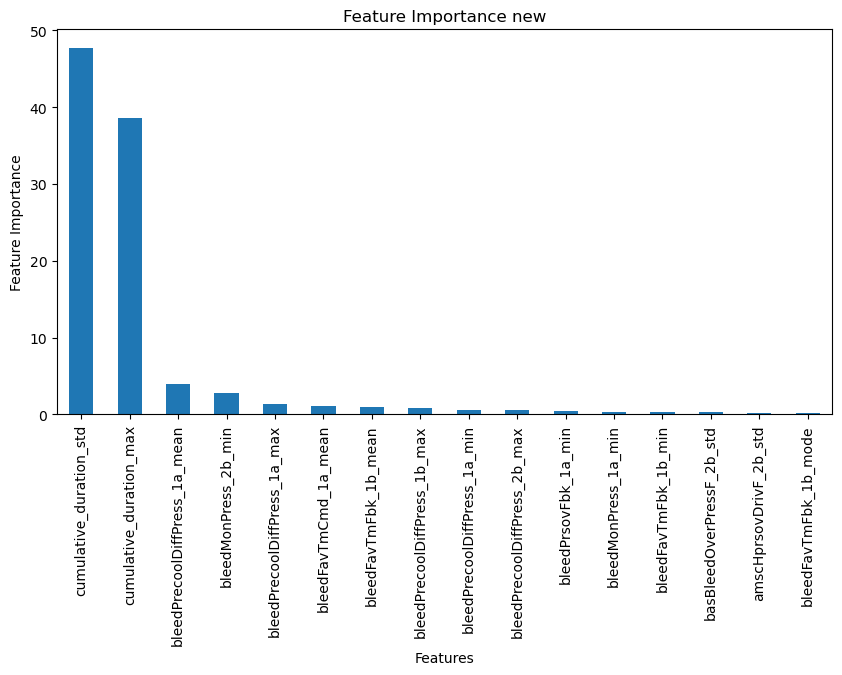

In [12]:
model.feature_importances_
name = "new"
#plot feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)*100
feat_importances = feat_importances[feat_importances> 0.1]
with open(f"./feature_selection/features_{name}.txt","w") as f:
    print(feat_importances.index.tolist())
    f.write(str(feat_importances.index.tolist()))
    f.close()
feat_importances.plot(kind="bar",title=f"Feature Importance {name}", figsize=(10,5), xlabel="Features", ylabel="Feature Importance")
plt.savefig(f"./feature_importances/feature_importance_{name}.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
emr = mean_absolute_error(y_test, y_pred)
emr_train = mean_absolute_error(y_train, model.predict(X_train))
print(f"Erro médio absoluto novo: {emr/(60*60*24)}")
print(f"Erro médio absoluto (treino) novo: {emr_train/(60*60*24)}")

Erro médio absoluto novo: 16.822374449927768
Erro médio absoluto (treino) novo: 16.95125258248811


In [14]:
df.to_parquet(f"./final_data/new/final_data.parquet")

In [15]:
import pickle
pickle.dump(model, open(f"./models_pickles/model_new.pkl", "wb"))
